In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from einops import rearrange
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_single, plot_next_multi

from mov_av import moving_average

In [2]:
SZ = 'small'
PDT = 24  # prediction length: any positive integer
CTX = 23 * 24  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 24  # batch size: any positive integer
TEST = 14 * PDT # test set length: any positive integer

NUM_WINDOWS = TEST - PDT
DIST = 1

In [3]:
moirai = MoiraiModule.from_pretrained(f"moirai_{SZ}_weights/")

Loading weights from local directory


In [4]:
data = pd.read_csv("monthly_hourly_load_values_2024.csv")
data = data.query("CountryCode == 'GR'").reset_index()
data = data.drop(["CreateDate", "UpdateDate", "CountryCode", "index", 
                  "MeasureItem", "DateShort", "TimeFrom", "TimeTo",
                  "Cov_ratio", "Value_ScaleTo100"], axis=1)
data['DateUTC'] = pd.to_datetime(data['DateUTC'], dayfirst=True)
data = data.set_index('DateUTC')
data = data.iloc[:(CTX+TEST), :]
data.to_csv('monthly_hourly_load_values_2024_processed.csv')

In [5]:
data.shape

(888, 1)

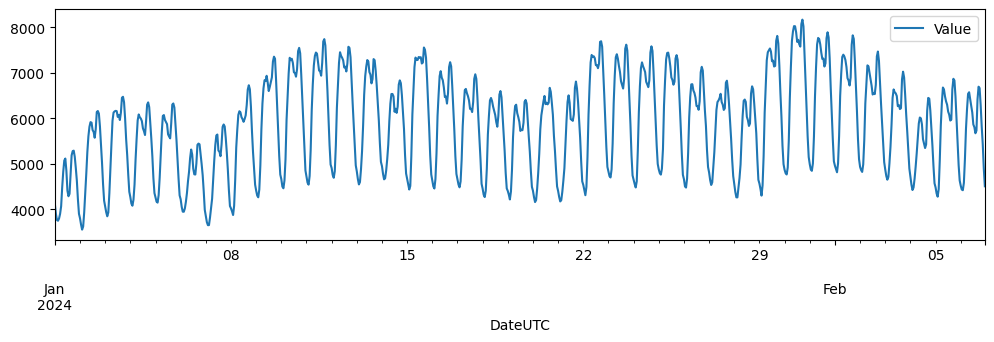

In [6]:
data.plot(figsize=(12, 3));

In [7]:
# # create a sample for the hourly data, using one week data as context window and predicting the next two days.
# inp = {
#     "target": data["Value"].to_numpy()[:168],  # 168 = 24 * 7
#     "start": data.index[0].to_period(freq="H"),
# }
# label = {
#     "target": data["Value"].to_numpy()[168:216],  # 48 = 24 * 2
#     "start": data.index[168].to_period(freq="H"),
# }

In [8]:
# Prepare model
model = MoiraiForecast(
    module=moirai,
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

In [9]:
# # Time series values. Shape: (batch, time, variate)
# past_target = rearrange(
#     torch.as_tensor(inp["target"], dtype=torch.float32), "t -> 1 t 1"
# )
# # 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
# past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# # 1s if the value is padding, 0s otherwise. Shape: (batch, time)
# past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

In [10]:
ds = PandasDataset(data, target='Value', freq='H')

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=NUM_WINDOWS,  # number of windows in rolling window evaluation
    distance=DIST, # number of time steps between each window - distance=PDT for non-overlapping windows
    max_history=None
)

In [11]:
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [12]:
# input_list = list(input_it)
# label_list = list(label_it)
# forecast_list = list(forecast_it)

In [13]:
errors = []
for i in range(NUM_WINDOWS):
    try:
        forecast = next(forecast_it).mean
    except:
        break
    
    target = data.iloc[CTX+(i*DIST) : CTX+(i*DIST)+PDT, :].values.reshape(-1)

    errors.append(np.mean(np.abs(target-forecast)))

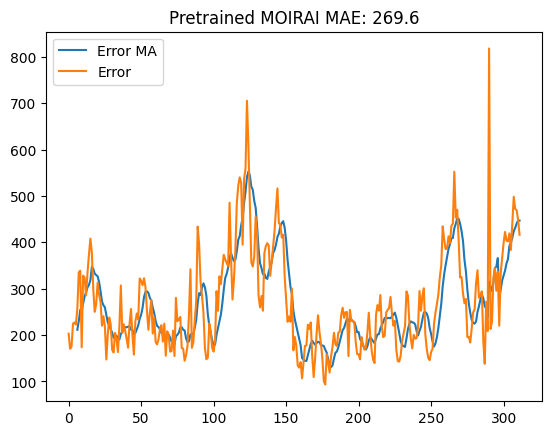

In [14]:
window_size = 7
plt.title(f"Pretrained MOIRAI MAE: {np.round(np.mean(errors), 2)}")
plt.plot(range(window_size-1,len(errors)), moving_average(np.array(errors), window_size), label='Error MA')
plt.plot(range(len(errors)), errors, label='Error')
plt.legend()
plt.savefig("pretrained_moirai_mae.png");

In [15]:
# Make predictions
if NUM_WINDOWS <= 8:
    predictor = model.create_predictor(batch_size=BSZ)
    forecasts = predictor.predict(test_data.input)
    
    input_it = iter(test_data.input)
    label_it = iter(test_data.label)
    forecast_it = iter(forecasts)
    
    fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 18))
    plot_next_multi(
        axes,
        input_it,
        label_it,
        forecast_it,
        context_length=2 * PDT,
        intervals=(0.9, 0.95),
        dim=None,
        name="Prediction",
        show_label=True,
    )
    plt.tight_layout()

    plt.savefig("pretrained_moirai_predictions.png");

In [16]:
experiment_run = "5th_run"
checkpoint = os.listdir(os.path.join("/Users/alexanderliapatis/Desktop/Projects/",
                                     f"uni2ts/outputs/finetune/moirai_1.0_R_small/load_data/{experiment_run}/checkpoints/"
                                     )
                       )[0]

fine_tuned_model = MoiraiForecast.load_from_checkpoint(
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
    checkpoint_path=os.path.join("/Users/alexanderliapatis/Desktop/Projects/",
                 f"uni2ts/outputs/finetune/moirai_1.0_R_small/load_data/{experiment_run}/checkpoints/{checkpoint}"
    )
)

In [17]:
predictor = fine_tuned_model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [18]:
errors = []
for i in range(NUM_WINDOWS):
    try:
        forecast = next(forecast_it).mean
    except:
        break
    
    target = data.iloc[CTX+(i*DIST) : CTX+(i*DIST)+PDT, :].values.reshape(-1)

    errors.append(np.mean(np.abs(target-forecast)))

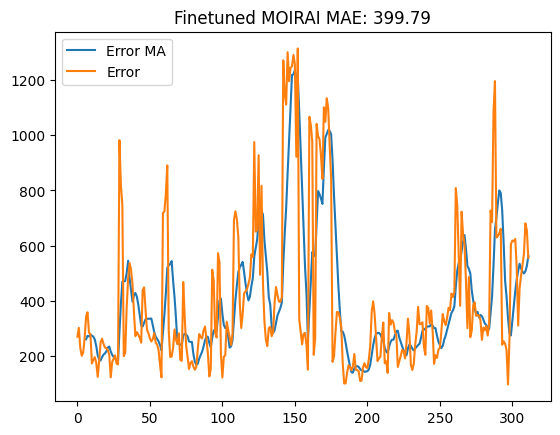

In [19]:
window_size = 7
plt.title(f"Finetuned MOIRAI MAE: {np.round(np.mean(errors), 2)}")
plt.plot(range(window_size-1,len(errors)), moving_average(np.array(errors), window_size), label='Error MA')
plt.plot(range(len(errors)), errors, label='Error')
plt.legend()
plt.savefig("finetuned_moirai_mae.png");

In [20]:
# Make predictions
if NUM_WINDOWS <= 8:
    predictor = fine_tuned_model.create_predictor(batch_size=BSZ)
    forecasts = predictor.predict(test_data.input)
    
    input_it = iter(test_data.input)
    label_it = iter(test_data.label)
    forecast_it = iter(forecasts)
    
    fig, axes = plt.subplots(nrows=NUM_WINDOWS, ncols=1, figsize=(8, 18))
    plot_next_multi(
        axes,
        input_it,
        label_it,
        forecast_it,
        context_length=2 * PDT,
        intervals=(0.9, 0.95),
        dim=None,
        name="Prediction",
        show_label=True,
    )
    plt.tight_layout()
    plt.savefig("finetuned_moirai_predictions.png");

In [21]:
# data['day_name'] = data.index.day_name()

In [22]:
# data.query("day_name == 'Sunday'")